# imports and general network functions

In [15]:
# imports
import numpy as np ; import pandas as pd
import matplotlib.pyplot as plt ; import matplotlib as mpl
import scipy.stats as stats ; 
import networkx as nx ; from math import comb as choose
from scipy.optimize import fsolve
from IPython.display import display, Math, Latex
import itertools as it
from IPython.display import display_html
# from itertools import chain,cycle

# imports
ranseed = 245

In [16]:
# average_degree(G)
def average_degree(G):
    degrees = G.degree()
    sum = 0
    for i in range(len(degrees)):
        sum += (degrees[i])

    average_degree = ( sum / len(G.nodes()) )
    return average_degree

# display pd.DataFrame()s side-by side
def display_side_by_side(*args,titles = it.cycle([''])):
    html_str=''
    for df,title in zip(args, it.chain(titles, it.cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
# define compare_summarries(df1,df2,q)
# take df1 and df2 as well as a common summary statistic, then plot the histograms of the two
def compare_summarries(df1, df2, q):
    fig, ax = plt.subplots(1, 1, figsize=(8,6));
    # plot qualities
    plt.hist( df1[q], bins = np.unique(df1[q]), color = "red", alpha = .9);
    plt.hist( df2[q], bins = np.unique(df2[q]), color = "blue", alpha = .9);
    # tidy plot
    plt.legend(["Config", "Chung-Lu"])
    plt.xlabel(str(q)) ; plt.title(f"Compare {q} for {sims} Config and Chung-Lu Simulations");

In [17]:
# define harmonic_centrality(g);
# input nx.Graph()
# output list of harmonic centralities for nodes and dataframe
def harmonic_centrality(g):
    # define array to return of harmonic centrality for all nodes
    hc = []; n =len(g.nodes)
    # define harmonic df
    h_df = pd.DataFrame(columns= ["Node","HC"])
    # loop through all nodes
    for ni in g.nodes:
        sum_ni = 0
        # calculate shortest path to all other nodes
        for nj in range(n):
            # avoid shortest path from a node to itself
            if nj != ni:
                # add 1/lij to running sum
                try : sum_ni += 1 / ( len(nx.shortest_path(g, source=ni, target=nj)) )
                # path DNE and thus 0 ; unnecessary to add
                except : sum_ni += ( 1 / np.infty)
        # find harmonic centrality for ni; sum for all 1/lij, where lij is shortest path, then divide by n-1
        hc.append( sum_ni / (n-1) )
        h_df.loc[ni] = ni, (sum_ni / (n-1))
    return hc, h_df

In [18]:
# define config_model(degrees)
# input : an array of degrees for all nodes in a network
# output : a matrix of ranomized stub connections and respective Graph
def config_model(degrees):

    # (a) "document" all stubs present in degree list
    all_stubs = []
    for d, n in zip(degrees, range(len(degrees)) ):
        for stub in range(d):
            all_stubs.append(n)

    # (b) randomly shuffle the degree list to create a random stub permutation
    np.random.shuffle(all_stubs)
    
    # prepare a matrix of zeros
    stub_matrix = np.zeros( (len(degrees), len(degrees)) )    
    # (c) loop through every pair of elements and let this be a connection of stubs
    while len(all_stubs) > 1:
        # pop first element of array twice; pop removes without replacement, thus two adjacent and different nodes
        stub1 = all_stubs.pop(0) ; stub2 = all_stubs.pop(0)
        # denote this node conenction in matrix symmetrically
        stub_matrix[stub1][stub2] = 1 ; stub_matrix[stub2][stub1] = 1
    
    stub_graph = nx.Graph(stub_matrix)
    return (stub_matrix, stub_graph)

# define chung_lu_model(degrees)
# input : an array of degrees for all nodes in a network
# output : a matrix of ranomized stub connections and respective Graph
def chung_lu_model(degrees):
    
    # (a) create array of p_i values
    m2 = np.sum(degrees)

    # instantiate matrix of zeros to loop through
    p_matrix = np.zeros( (len(degrees), len(degrees)) )    
    
    # (b) loop through node pair and create p_matrix
    for row, n1 in zip(p_matrix, range(len(p_matrix)) ):
        ki = degrees[n1]
        
        for n2 in range(len(row)):
            kj = degrees[n2]
            pij = (ki*kj / m2)
            if pij > 1: pij = np.floor(pij)
            p_matrix[n1][n2] = pij

    # (c) create adjacency matrix (via p_matrix and bernoulli trials) and Graph object
    A = stats.bernoulli.rvs(p_matrix)
    chung_lu_graph = nx.Graph(A)
    return (A, chung_lu_graph)

In [19]:
# define plot_network(graph, layout, cmap, measure, measure_label, node_labels, positions)
# input g : nx.Graph object
# input layout : pass in nx.??_layout, whichever most appropriate
# input measure : list of measurement by which to color each node (degree, harmonic centrality, etc.)
# input measure_label : name of measurement to put on colorbar
# input node_labels : labels for nodes
# input positions : preset positions for nodes
# output drawn network with given specifications
def plot_network(g, layout, cmap, measure, measure_label, node_labels, positions = None):
    # prepare plot
    fig = plt.gcf() ; fig.set_size_inches(10, 8)
    if positions == None: layout = layout(g);
    else : layout = layout(g, pos = positions);
    # plot graph
    if node_labels == False:
        nx.draw(g, pos = layout, with_labels = True, node_color = measure, cmap = cmap, vmax = max(measure) )
    else :
        nx.draw(g, pos = layout, with_labels = False, node_color = measure, cmap = cmap, vmax = max(measure) ,
                node_size = [10*len(node_labels[i])**2 for i in layout])
        # labels
        nx.draw_networkx_labels(g, pos=layout, labels=node_labels, font_weight="bold", font_color="black")
    # plot colorbar
    color_scale = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(measure), vmax=max(measure)))
    plt.colorbar(color_scale, fraction=0.025, aspect=18, label = measure_label);

# (2.3) G(n,p) Communities, $p_m = A*(n_m-1)^{-B}$

In [20]:
# (2.3) create an inputted K G(n,p) networks using pm = A(nm-1)^-B
# define communities(K,A,B)
# input K
# input A
# input B
# output 
def communities(K, A, B):
    
    # determine random n and p for each community K  
    n_list = [] ; p_list = []
    for m in range( K ):
#         # random n and p ; throw error if p >  1?
#         n_m = int(stats.norm(40,5).rvs()) ; 
        n_m = 10*(m+1) ; p_m = A*(n_m - 1)**(-B)
        n_list.append( n_m ) ; p_list.append(p_m);
        
    # for K G(n,p)communities create 1 sum(n_i) x sum(n_i) matrix 
    size = np.sum(n_list)
    matrix = []
    # prepare empty matrix of size sum(n_i) x sum(n_i)
    for row in range(size):
        row = [0] * size  
        matrix.append(row)

    # fill matrix for all communities
    cumul_commun = 0
    for m,pm in zip(range(len(n_list)), p_list):
        # for each row
        for r in range(cumul_commun, (cumul_commun + n_list[m]) ):
            row = matrix[r]
            # add connections in each community and only that community
            for c in range(cumul_commun , (cumul_commun + n_list[m]) ):
                row[c] = stats.bernoulli(pm).rvs()
                # avoid self-loops
                if (c) == r:
                    row[c] = 0

        # go to next community
        cumul_commun += n_list[m]
    matrix = np.asarray(matrix)
    
    # create a dictionary where each community has their own square matrix (for calculations)
    # dictionary of each community; however, currently n_i x sum(n_i)
    cumul_commun = 0 ; communities1 = {}
    for com,num in zip(n_list, range(len(n_list)) ):
        communities1[num] = matrix[cumul_commun : cumul_commun + com]    
        cumul_commun += com

    # convert each community to a square matrix of n_i x n_i
    cumul_commun = 0; communities = {}
    for com in communities1:    
        # matrix per community
        com_mat = []
        for node in (communities1[com]):
            node = node[ cumul_commun : cumul_commun + communities1[com].shape[0] ]
            com_mat.append(node)
        communities[com] = np.asarray(com_mat) + np.asarray(com_mat).T - np.diag(np.diag(np.asarray(com_mat)))
        # loop to next community by adding the size of the current community
        cumul_commun += communities1[com].shape[0]

    return n_list, p_list,communities, matrix

In [21]:
# input K groups, A, B
K = 6; A = 3; B = 1.8
ns, ps, communitys, whole_network = communities(K,A,B)

In [22]:
# average degree per community
print("Average Degrees : ")

degree_l = []
cluster_l = []
# for each community, record degree and clustering
for i,ni,pi in zip(communitys, ns, ps):
    G = nx.Graph(communitys[i])
    print("For n = ", ni, "p = ", round(pi,5), ":")

    degree = (pi*(ni-1))  ; cluster = ( (pi*(ni-1)) ) / ni
    degree_l.append(degree) ; cluster_l.append(cluster)
    
    print("<k_", i, ">=", round(average_degree(G),4), " ; ",
          "E[k_m]=", round(degree , 4) ,  " ; ",
          "E[C_m]=", round(cluster , 4),  " ; ", sep="")

Average Degrees : 
For n =  10 p =  0.05748 :
<k_0>=1.0 ; E[k_m]=0.5173 ; E[C_m]=0.0517 ; 
For n =  20 p =  0.01497 :
<k_1>=0.7 ; E[k_m]=0.2845 ; E[C_m]=0.0142 ; 
For n =  30 p =  0.007 :
<k_2>=0.2 ; E[k_m]=0.2029 ; E[C_m]=0.0068 ; 
For n =  40 p =  0.0041 :
<k_3>=0.05 ; E[k_m]=0.1601 ; E[C_m]=0.004 ; 
For n =  50 p =  0.00272 :
<k_4>=0.36 ; E[k_m]=0.1333 ; E[C_m]=0.0027 ; 
For n =  60 p =  0.00195 :
<k_5>=0.1667 ; E[k_m]=0.1149 ; E[C_m]=0.0019 ; 


# (2.5) Expectation Maximization

In [23]:
# (5.5) E step and M step functions
# input lam0,lam1,p from either m-step or initial guess, actual data X and its dimensions n
def e_step(lam0, lam1, p, X, n):
    Q = np.zeros((n, n))
    for i, j in it.combinations(range(n), 2):
        a = ( (p)*(lam1**X[i,j])*(np.exp(-lam1)) )
        b = ( (1-p)*(lam0**X[i,j])*(np.exp(-lam0)) )
        Q[i, j] = Q[j, i] = a / (a + b)
    return Q

# input Q from E step, the actual data X and its dimensions n
def m_step(Q, X, n):
    d = -1
    lam0 = np.sum(np.triu((1-Q)*X,d)) / ( np.sum( np.triu(1-Q, d)) ) 
    lam1 = np.sum(np.triu(Q*X,d)) / ( np.sum( np.triu(Q, d)) )
    p = np.sum(np.triu(Q, d)) / ( choose(n,2) )
    return lam0, lam1, p

# (5.6) sim_random(Q) simulates a random graph of the data size using Qij but with unweighted edges
def sim_random(Q):
    n = Q.shape[0]
    g = nx.Graph()
    # loop over every pairs i,j and connect them with probability Q_ij
    for i, j in it.combinations(range(n), 2):
        if np.random.rand() < Q[i,j]:
            g.add_edge(i, j)
    return g

# (5.7) simualte_data(Q) simulates matrices rather than drawn networks
def simulate_data(Q):
    m = []
    # loop over every pairs i,j and connect them with probability Q_ij
    for i,count in zip(Q, range(len(Q)) ):
        mi = []
        # lower diagonal of 0s
        for j in i[:count]:
            mi.append(0)
        # diagonal of 0s and upper diagonal of Poisson simulations
        for j in i[count:]:
            # diagonal of 0s
            if j == 0 : mi.append(0)
            # upper diagonal of Poisson simulations
            else:
                if (np.random.rand() < j) : mi.append(np.random.poisson(lam1))
                else :  mi.append(np.random.poisson(lam0))
        m.append(np.asarray(mi) )
    # make matrix symmetric
    m = np.asarray(m)
    m = m + m.T - np.diag(np.diag(m))
    return m

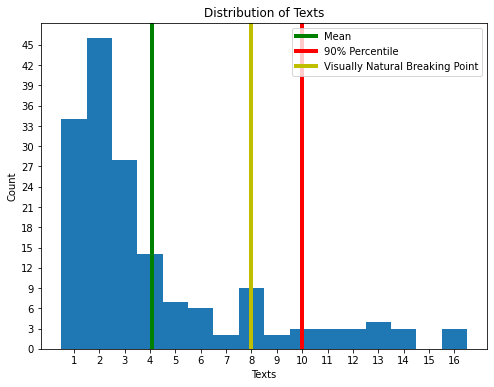

In [24]:
# (5.6) read in data, convert to graph, glimpse at data (textlog, text_g)
textlog = ( pd.read_csv(r"text_logs.txt", delimiter=" ", header = None) )
textlog = textlog.rename(columns={0:"A", 1:"B", 2:"Texts"})
# build graph object; read in edges with weights
text_g = nx.Graph()
for i in textlog.iloc:
    text_g.add_edge(i[0],i[1], weight = i[2])
# make textlog a matrix
text_m = nx.to_numpy_matrix(text_g, dtype = int)
text_matrix = []
for i in range( len(text_m) ):
    text_matrix.append(np.ravel(text_m[i][0]))
text_matrix = np.asarray(text_matrix)


# convert = text_matrix as boolean for presence of an edge
text_present = text_matrix
text_present =  text_present.astype(bool)
text_present =  text_present.astype(int)

# glimpse at text distributions
fig = plt.gcf() ; fig.set_size_inches(8, 6)
plt.hist(textlog["Texts"], bins=np.arange(17)+0.5 )
plt.axvline(np.mean(textlog["Texts"]), color="g",linewidth = 4); #mean line
plt.axvline(np.percentile( textlog["Texts"], 90 ), color="r", linewidth = 4); #.9 percentile line
plt.axvline(8, color="y", linewidth = 4); #visually natural breaking point
# labels
plt.xlabel("Texts"); plt.xticks(np.arange(1, 17, step=1))
plt.ylabel("Count"); plt.yticks(np.arange(0, 47, step=3))
plt.title("Distribution of Texts"); plt.legend(["Mean","90% Percentile", "Visually Natural Breaking Point"]);

12
13 friends, 154 acquaintances; Friend % :  0.08441558441558442
Mean Texts for Friends :  13.692307692307692
Mean Texts for Non-Friends :  3.272727272727273


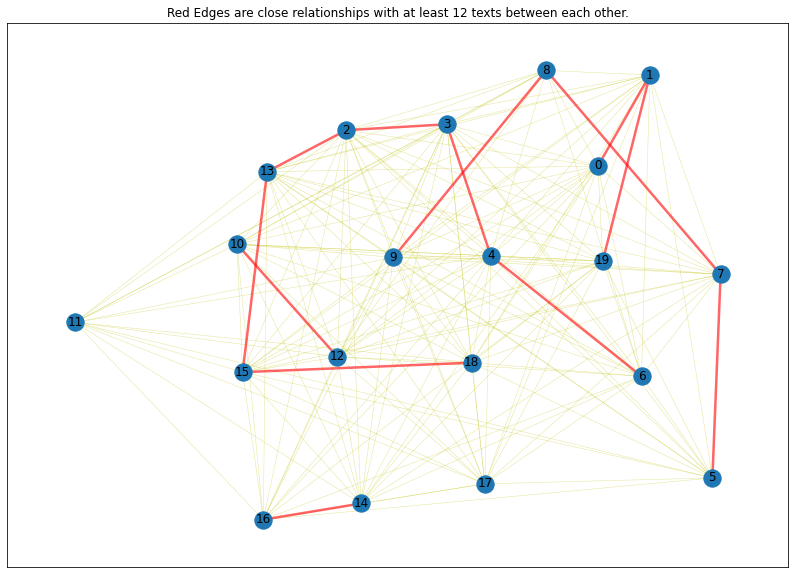

In [25]:
# (5.6) assume and input lam1 to examine network ;  if > input, red and close else yellow and not close
min_texts = int(input()) ; acq = [] ; friends = []; acq_w = []; friends_w = [];
# for edges with less than 8 texts, assume acquaintances
for e,e2 in zip(text_g.edges(data=False),text_g.edges(data=True) ):
    w = e2[2]["weight"]
    if (w >= min_texts): friends.append(e); friends_w.append(w);
    else : acq.append(e); acq_w.append(w)      
print(len(friends), "friends,", len(acq), "acquaintances; Friend % : ", len(friends)/len(acq))
print("Mean Texts for Friends : ", np.mean(friends_w) )
print("Mean Texts for Non-Friends : ", np.mean(acq_w) )

# prepare plot for network
fig = plt.gcf() ; fig.set_size_inches(14, 10)
pos = nx.spring_layout(text_g) ; # pos = nx.kamada_kawai_layout(text_g) ; 
# plot network, color edges by categorical number of texts
nx.draw_networkx_nodes(text_g.nodes, pos = pos);
nx.draw_networkx_edges(text_g, width=0.5, alpha=0.4, pos = pos, edgelist= acq,  edge_color='y');
nx.draw_networkx_edges(text_g, width=2.5, alpha=0.6, pos = pos, edgelist= friends,  edge_color='r');
nx.draw_networkx_labels(text_g,pos);
plt.title("Red Edges are close relationships with at least "+str(min_texts)+" texts between each other.");

In [26]:
# (5.6) E-M algorithm on poisson network to maximize theta
# initialize theta
lam0 = np.mean(acq_w) ; lam1 = np.mean(friends_w); p = .5 ; n = len(text_g)

# run for several iterations ; 
iter = 20; trajectory = np.zeros((iter, 3))
for i in range(iter):
    trajectory[i] = [lam0,lam1,p] ;
    Q = e_step(lam0,lam1,p, text_matrix, n) # pass in actual data as a matrix X
    lam0,lam1,p = m_step(Q, text_matrix, n)
print("E-M Algorithm returns the following point estimate : \n [lam0,lam1,p] = " , trajectory[-1])

E-M Algorithm returns the following point estimate : 
 [lam0,lam1,p] =  [1.7093805  9.72301067 0.29459798]


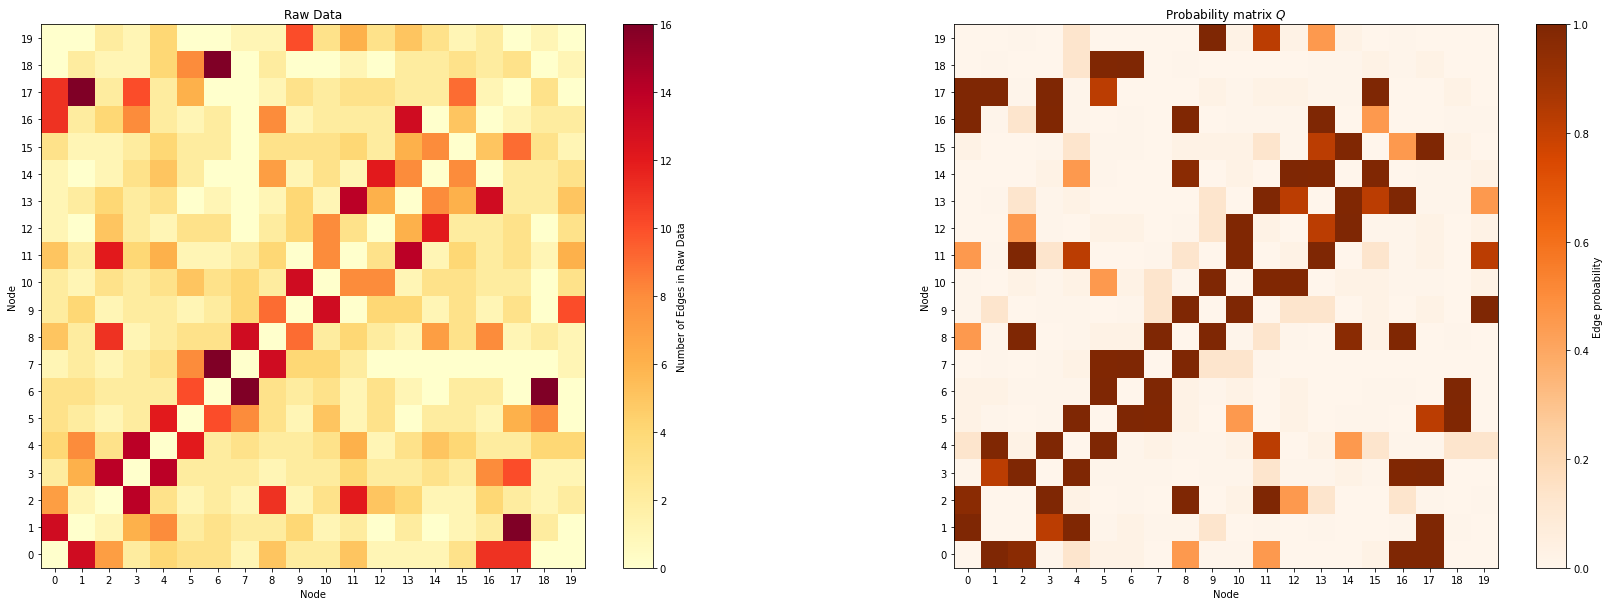

In [27]:
# (5.6) plot raw data as a colorplot
# size of plot
plt.figure(figsize=(30,10) ); 

# plot raw data on heatmap and label colorbar
plt.subplot(121);plt.title("Raw Data");
plt.imshow(text_matrix, origin='lower', cmap = plt.get_cmap("YlOrRd") );
plt.colorbar(fraction=0.05, aspect=18, label='Number of Edges in Raw Data');
plt.xlabel("Node"); plt.xticks(np.arange(0, 20, step=1));
plt.ylabel("Node"); plt.yticks(np.arange(0, 20, step=1));

# # (5.6) Q color plot
plt.subplot(122)
plt.title(r'Probability matrix $Q$');
plt.imshow(Q, origin='lower', cmap=plt.cm.Oranges, vmin=0, vmax=1);
plt.colorbar(fraction=0.05, aspect=18, label='Edge probability');
plt.xlabel("Node"); plt.xticks(np.arange(0, 20, step=1));
plt.ylabel("Node"); plt.yticks(np.arange(0, 20, step=1));

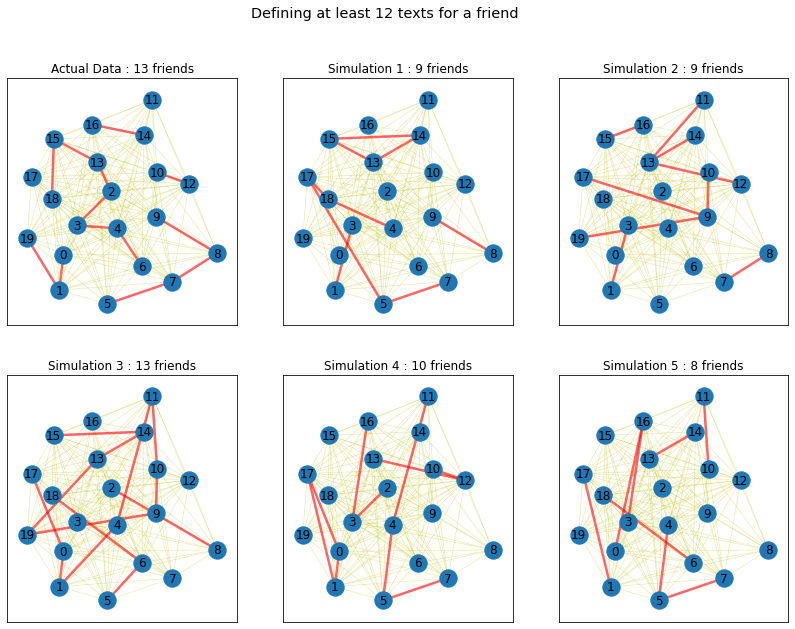

In [28]:
# (5.6) draw a few networks simulated with q(A) JUST lam1
fig = plt.figure(figsize=(20,14))
fig.suptitle("Defining at least " + str(min_texts) + " texts for a friend", fontsize="x-large")

rows = 2 ; columns = 3
pos = nx.spring_layout(text_g)

# plot actual ; put in for loop just to code fold and make more readable
for a in range(1,2):
    plt.subplot(2, 3, a)
    # prepare plot for network
    fig = plt.gcf() ; fig.set_size_inches(14, 10)
    pos = nx.spring_layout(text_g) ; # pos = nx.kamada_kawai_layout(text_g) ; 
    # plot network, color edges by categorical number of texts
    nx.draw_networkx_nodes(text_g.nodes, pos = pos);
    nx.draw_networkx_edges(text_g, width=0.5, alpha=0.4, pos = pos, edgelist= acq,  edge_color='y');
    nx.draw_networkx_edges(text_g, width=2.5, alpha=0.6, pos = pos, edgelist= friends,  edge_color='r');
    nx.draw_networkx_labels(text_g,pos);
    plt.title("Actual Data : " + str(len(friends)) + " friends");

# plot 5 simulations
for i in range(1, 6):
    friends_est = [] ; acq_est = [];
    g_estimated = sim_random(Q)
    
    sim_texts_l = []
    for e,e2 in zip(text_g.edges(data=False), text_g.edges(data=True)):
        w = e2[2]["weight"]        
        # loop through simulation edges and compare to actual data to make estimate
        if e in g_estimated.edges():
            # loop through actual friends
            if w >= min_texts:
                sim_texts = np.random.poisson(lam1)
                sim_texts_l.append(sim_texts)
                # hopefully lam1 will simulate values > min_texts, predicting a friend
                if  sim_texts >= min_texts: friends_est.append(e)
                # but sometimes lam1 will simulate small values, predicting a non friend
                else : acq_est.append(e)         
            # loop through acquaintances
            else:
                sim_texts = np.random.poisson(lam1)
                sim_texts_l.append(sim_texts)
                # lam0 may happen to be large enough to predict a friend
                if sim_texts >= min_texts: friends_est.append(e)
                # typically lam0 will predict non-friends
                else : acq_est.append(e)
        # for edges not in data, no texts were shared and thus simulate lam0
        else : 
            sim_texts = np.random.poisson(lam1)
            sim_texts_l.append(sim_texts)
            # lam0 may happen to be large enough to predict a friend
            if np.random.poisson(lam0) >= min_texts: friends_est.append(e)
            # typically lam0 will predict non-friends
            else : acq_est.append(e)
            

    # plot network, color edges by categorical number of texts
    fig.add_subplot(rows, columns, i+1)
    nx.draw_networkx_nodes(g_estimated.nodes, pos = pos);
    nx.draw_networkx_edges(g_estimated, width=0.5, alpha=0.4, pos = pos, edgelist= acq_est,  edge_color='y');
    nx.draw_networkx_edges(g_estimated, width=2.5, alpha=0.6, pos = pos, edgelist= friends_est,  edge_color='r');
    nx.draw_networkx_labels(g_estimated,pos);
    plt.title("Simulation "+str(i)+" : "+str(len(friends_est))+" friends")  
          

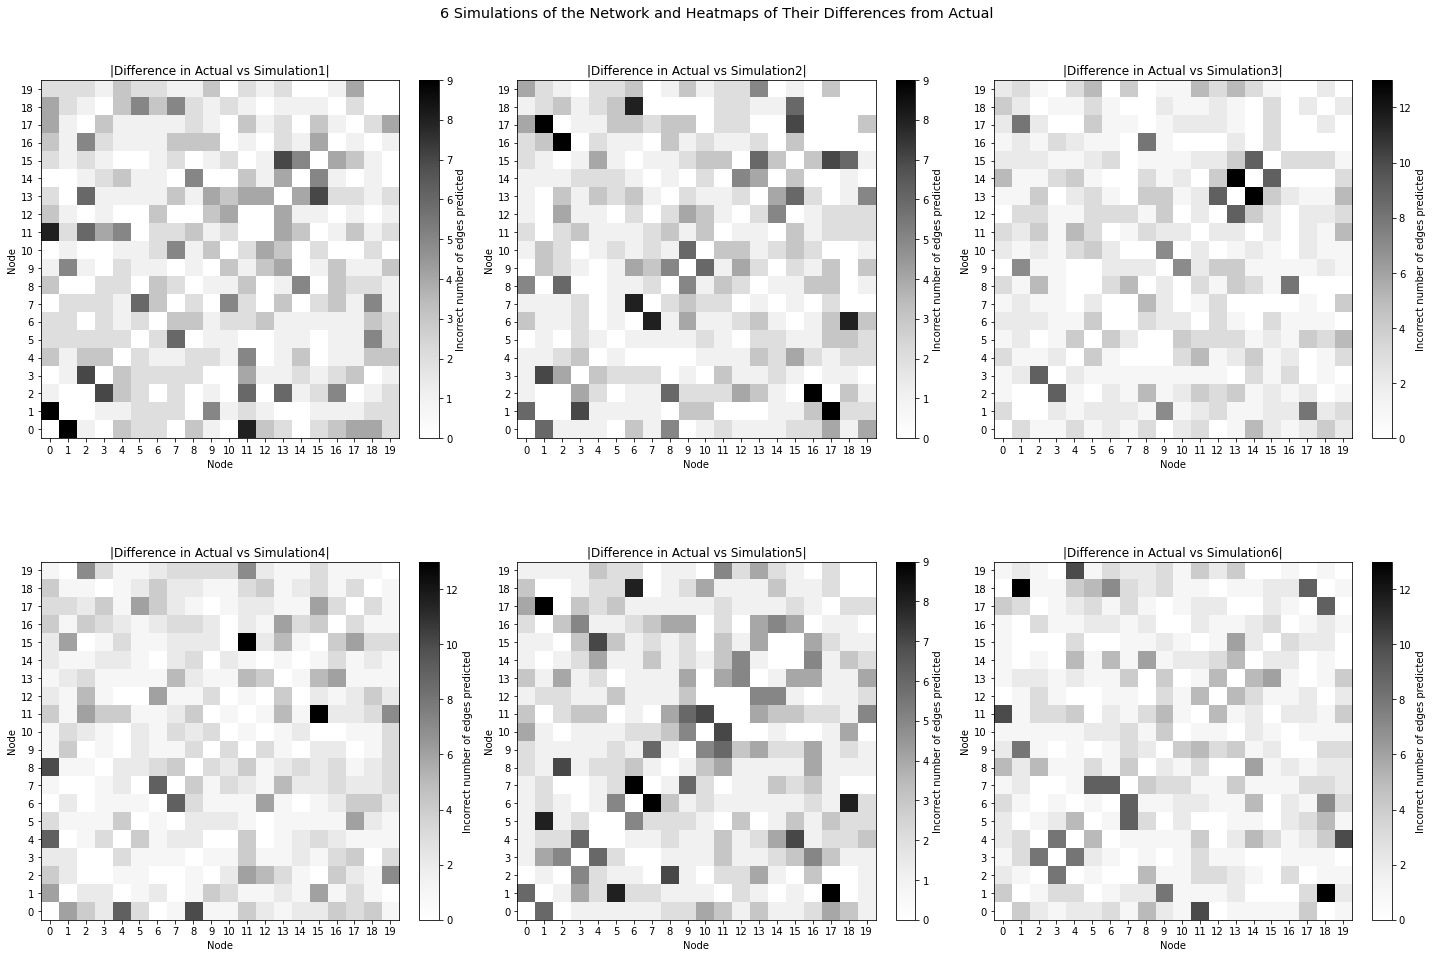

In [29]:
# (5.7) several heat maps to notice trends
fig = plt.figure(figsize=(20,14))
fig.suptitle("6 Simulations of the Network and Heatmaps of Their Differences from Actual", 
fontsize="x-large")

rows = 2 ; columns = 3
pos = nx.spring_layout(text_g)

for i in range (1,7): 
    # run data
    diff_matrix = np.abs( text_matrix  - simulate_data(Q))
    errors_list = ( diff_matrix[np.triu_indices(20, 1)] )
    fig.add_subplot(rows, columns, i)
    plt.title("|Difference in Actual vs Simulation" + str(i) + "|");
    plt.imshow(np.abs(diff_matrix), origin='lower', cmap = "Greys" );
    plt.colorbar(fraction=0.05, aspect=18, label='Incorrect number of edges predicted');
    plt.xlabel("Node"); plt.xticks(np.arange(0, 20, step=1));
    plt.ylabel("Node"); plt.yticks(np.arange(0, 20, step=1));
plt.tight_layout()

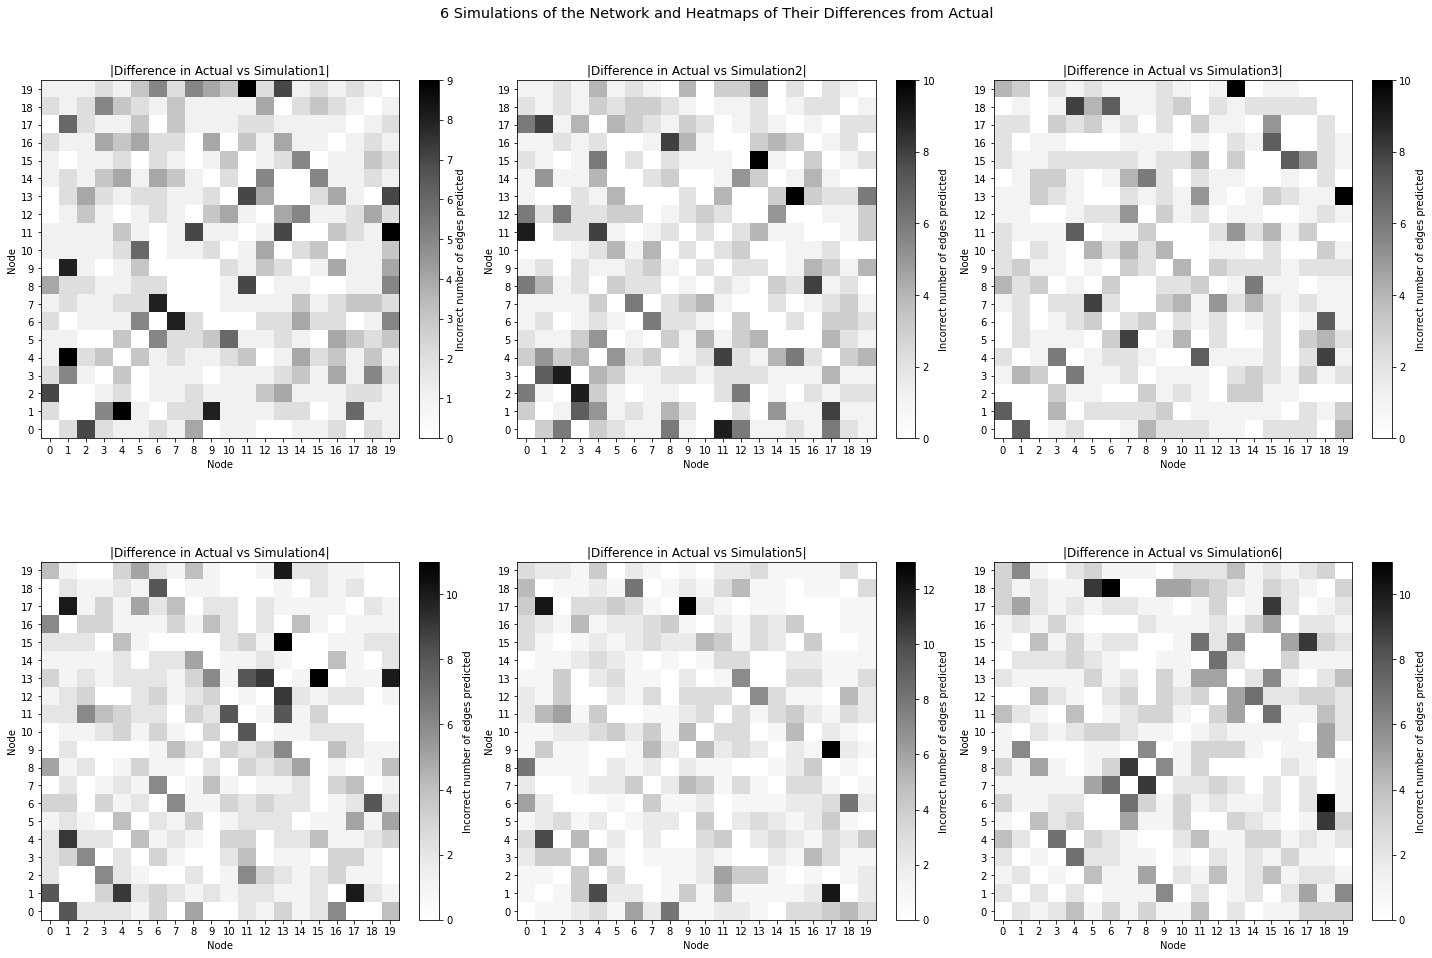

In [30]:
# (5.7) several heat maps to notice trends
fig = plt.figure(figsize=(20,14))
fig.suptitle("6 Simulations of the Network and Heatmaps of Their Differences from Actual", 
fontsize="x-large")

rows = 2 ; columns = 3
pos = nx.spring_layout(text_g)

for i in range (1,7): 
    # run data
    diff_matrix = np.abs( text_matrix  - simulate_data(Q))
    errors_list = ( diff_matrix[np.triu_indices(20, 1)] )
    fig.add_subplot(rows, columns, i)
    plt.title("|Difference in Actual vs Simulation" + str(i) + "|");
    plt.imshow(np.abs(diff_matrix), origin='lower', cmap = "Greys" );
    plt.colorbar(fraction=0.05, aspect=18, label='Incorrect number of edges predicted');
    plt.xlabel("Node"); plt.xticks(np.arange(0, 20, step=1));
    plt.ylabel("Node"); plt.yticks(np.arange(0, 20, step=1));
plt.tight_layout()

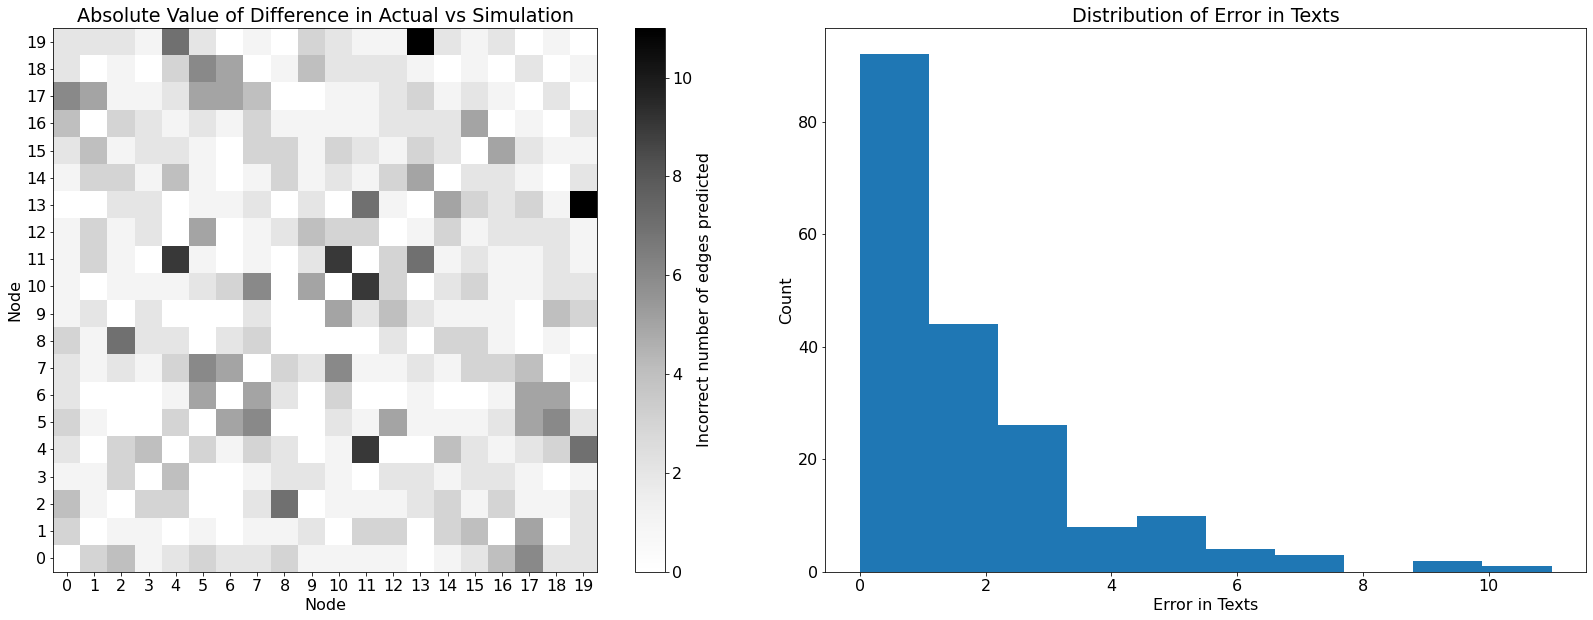

In [31]:
# (5.7) plot raw data as a colorplot
plt.figure(figsize=(30,10) ); plt.rcParams.update({'font.size': 16});

# run data
diff_matrix = np.abs( text_matrix  - simulate_data(Q))
errors_list = ( diff_matrix[np.triu_indices(20, 1)] )

# size of plot
plt.subplot(121)
# plot difference on heatmap and label colorbar
plt.title("Absolute Value of Difference in Actual vs Simulation");
plt.imshow(np.abs(diff_matrix), origin='lower', cmap = "Greys" );
plt.colorbar(fraction=0.05, aspect=18, label='Incorrect number of edges predicted');
plt.xlabel("Node"); plt.xticks(np.arange(0, 20, step=1));
plt.ylabel("Node"); plt.yticks(np.arange(0, 20, step=1));

# hist of errors for clarity
plt.subplot(122)
plt.hist(errors_list, bins = 10);
# labels
plt.xlabel("Error in Texts"); plt.ylabel("Count");
plt.title("Distribution of Error in Texts"); 

# (3.2) Configuration Model, Chung_Lu Model

In [32]:
degrees=[8,5,5,4,3,2,2,2,1,1,1,1,1,1,1]

# draw config example from networkx
goal = nx.configuration_model(degrees, seed=ranseed)
cmap = "YlOrRd"

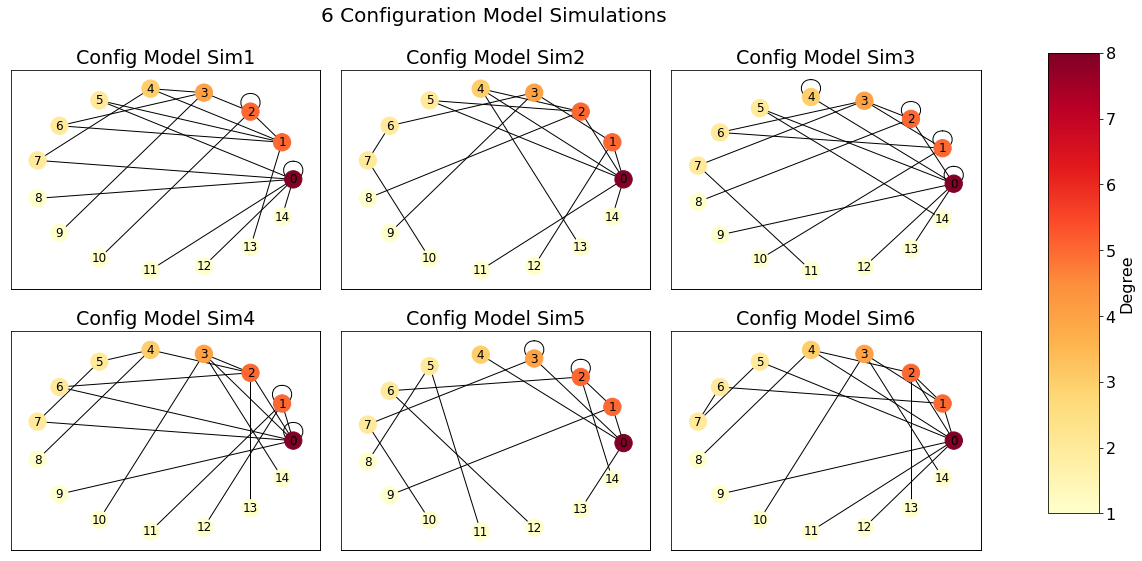

In [33]:
# (2.3) run and plot configuration model
rows = 2 ; columns = 3 ; fig, ax = plt.subplots(rows, columns, figsize=(14,8))
pos = nx.circular_layout(goal) ; colors = plt.cm.YlOrRd ; 
plt.suptitle("6 Configuration Model Simulations", size = 20)
color_scale = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin = min(degrees), vmax=max(degrees)))

# prepare simulations and a summed/average adjacency matrix A = a_avg_config
sims = 1000; a_avg_config = np.zeros( (len(degrees), len(degrees)) )
# run sims simulations from the configuration model; 600 for A but only plot 6
for i in range(0, sims):
    # create configuration model ; add adjacency matrix to a_avg_config and prepare Graph object
    a_avg_config += config_model(degrees)[0]
    config_plot = config_model(degrees)[1]
    # only plot .01*sims=6 simulations
    if i < (.006*sims):
        # plot network, color edges by categorical number of texts
        fig.add_subplot(rows, columns, i+1)
        nx.draw_networkx_nodes( config_plot, pos = pos, node_color = degrees, cmap = colors);
        nx.draw_networkx_edges( config_plot, pos = pos);
        nx.draw_networkx_labels(config_plot, pos = pos);
        plt.title(f"Config Model Sim{i+1}"); 
# average adjacency matrix for config model
a_avg_config = (a_avg_config / sims) 

# tidy plot
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # remove axes
plt.tight_layout();
# grand colorbar 
cax = fig.add_axes([1.05, 0.1, 0.05, .8]) # left, bottom, width, height
fig.colorbar( color_scale, fraction=0.5, aspect=18, label='Degree', cax=cax);

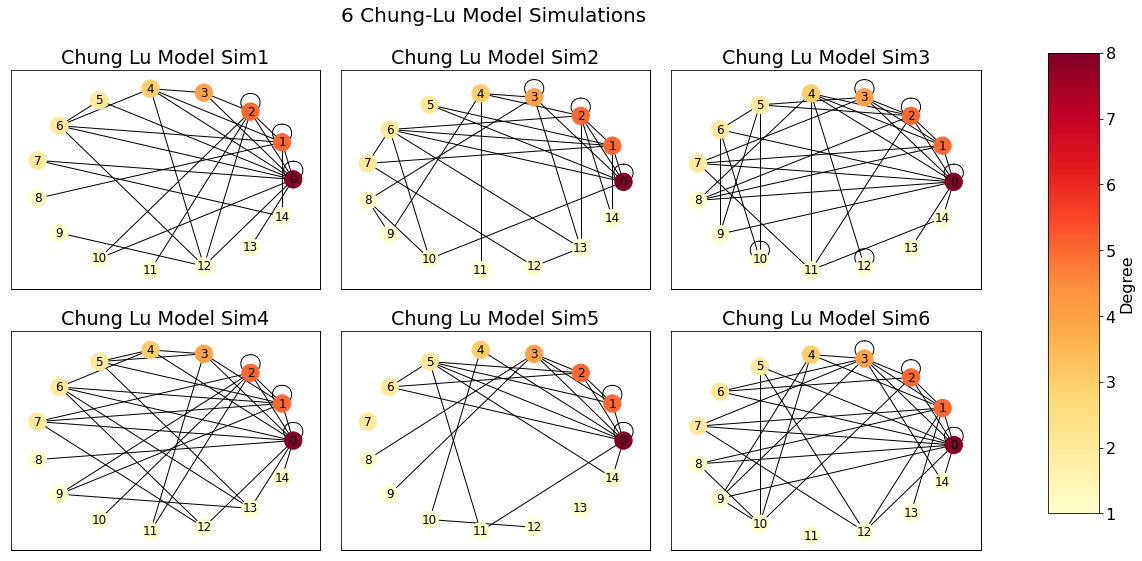

In [34]:
# (2.3) run and plot chung_lu model
rows = 2 ; columns = 3 ; fig, ax = plt.subplots(rows, columns, figsize=(14,8))
pos = nx.circular_layout(goal) ; colors = plt.cm.YlOrRd ; 
color_scale = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin = min(degrees), vmax=max(degrees)))
plt.suptitle("6 Chung-Lu Model Simulations", size = 20)

# prepare simulations and a summed/average adjacency matrix A = a_avg_chung_lu
sims = 1000; a_avg_chung_lu = np.zeros( (len(degrees), len(degrees)) )
# run sims simulations from the chung_lu model; 600 for A but only plot 6
for i in range(0, sims):
    # create chung_lu model ; add adjacency matrix to a_avg_chung_lu and prepare Graph object
    a_avg_chung_lu += chung_lu_model(degrees)[0]
    chung_lu_plot = chung_lu_model(degrees)[1]
    # only plot .01*sims=6 simulations
    if i < (.006*sims):
        # plot network, color edges by categorical number of texts
        fig.add_subplot(rows, columns, i+1)
        nx.draw_networkx_nodes( chung_lu_plot, pos = pos, node_color = degrees, cmap = colors);
        nx.draw_networkx_edges( chung_lu_plot, pos = pos);
        nx.draw_networkx_labels(chung_lu_plot, pos = pos);
        plt.title(f"Chung Lu Model Sim{i+1}"); 
# average adjacency matrix for chung_lu model
a_avg_chung_lu = np.round(a_avg_chung_lu / sims, 3) 


plt.tight_layout();

# tidy plot
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # remove axes
plt.tight_layout();
# grand colorbar 
cax = fig.add_axes([1.05, 0.1, 0.05, .8]) # left, bottom, width, height
fig.colorbar( color_scale, fraction=0.5, aspect=18, label='Degree', cax=cax);

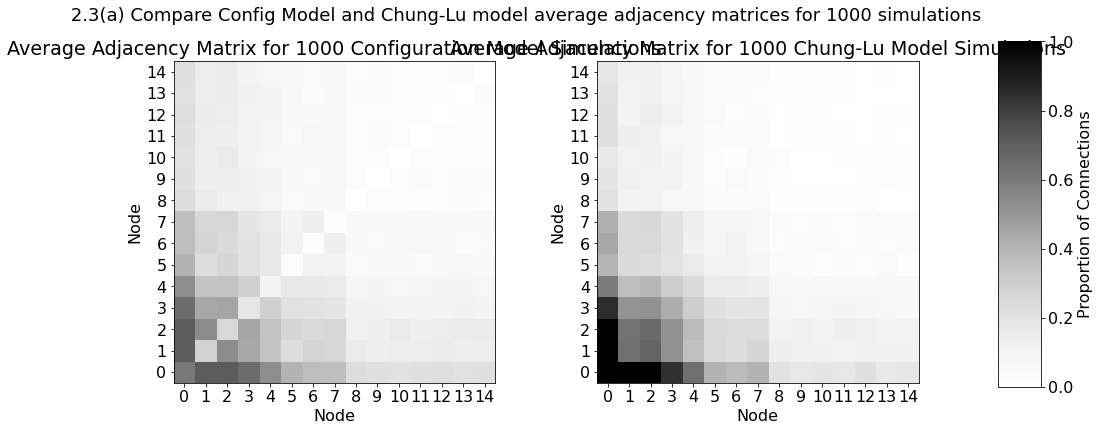

In [35]:
# 2.3(a) plot adjacency matrices as heat maps for config and chung-lu
# size of plot and prepare colorbar
fig, ax = plt.subplots(1, 2, figsize=(12,6));
color_scale = plt.cm.ScalarMappable(cmap="Greys", norm=plt.Normalize(vmin = 0, vmax = 1) );
plt.suptitle(f" 2.3(a) Compare Config Model and Chung-Lu model average adjacency matrices for {sims} simulations", 
             size = 18);

# plot heatmap of average adjacency matrix ; config model
plt.subplot(121)
plt.title(f"Average Adjacency Matrix for {sims} Configuration Model Simulations");
plt.imshow(a_avg_config, origin='lower', cmap = plt.get_cmap("Greys"), vmax=1 );
plt.xlabel("Node"); plt.xticks(np.arange(0, 15, step=1));
plt.ylabel("Node"); plt.yticks(np.arange(0, 15, step=1));

# plot heatmap of average adjacency matrix ; chung-lu model
plt.subplot(122)
plt.title(f"Average Adjacency Matrix for {sims} Chung-Lu Model Simulations");
plt.imshow(a_avg_chung_lu, origin='lower', cmap = plt.get_cmap("Greys") );
plt.xlabel("Node"); plt.xticks(np.arange(0, 15, step=1));
plt.ylabel("Node"); plt.yticks(np.arange(0, 15, step=1));
plt.tight_layout();

# grand colorbar 
cax = fig.add_axes([1.05, 0.1, 0.05, .8]); # [far left, .1 off bottom, narrow, up to .9]
fig.colorbar(color_scale, fraction=0.5, aspect=18, label='Proportion of Connections', cax=cax);

In [36]:
# dataframe of simulations of config and chung-lu
config_df = pd.DataFrame(columns = ["avg_degrees","densities","clusterings", "giant", "transitivity"])
chung_lu_df = pd.DataFrame(columns = ["avg_degrees","densities","clusterings", "giant", "transitivity"])

sims = 1000
for sim in range(sims):
    # create a configuration model and chung-lu model simulation
    sim_config = config_model(degrees)[1]
    sim_chung_lu = chung_lu_model(degrees)[1]

    
    # append config summary stats
    avg_deg = np.mean(sim_config.degree) ; dens = nx.density(sim_config) ; clust = nx.average_clustering(sim_config)
    graph_components = sorted(nx.connected_components(sim_config), key=len, reverse=True)
    giant_component = len( graph_components[0] )
    transitivity = nx.transitivity(sim_config)
    config_df.loc[sim] = (avg_deg,dens,clust, giant_component, transitivity)
    
    # append chung_lu summary stats    
    avg_deg = np.mean(sim_chung_lu.degree) ; dens = nx.density(sim_chung_lu) ; clust = nx.average_clustering(sim_chung_lu)
    graph_components = sorted(nx.connected_components(sim_chung_lu), key=len, reverse=True)
    giant_component = len(graph_components[0])
    transitivity = nx.transitivity(sim_chung_lu)

    chung_lu_df.loc[sim] = (avg_deg,dens,clust,giant_component, transitivity)

# compare summary statistics
display_side_by_side( np.round(config_df.describe(),3), 
                      np.round(chung_lu_df.describe(),3), titles=["Config", "Chung-Lu"])

,avg_degrees,densities,clusterings,giant,transitivity
count,1000.000,1000.000,1000.000,1000.000,1000.000
mean,4.639,0.163,0.095,13.135,0.141
std,0.071,0.010,0.073,1.794,0.097
min,4.433,0.133,0.000,5.000,0.000
25%,4.567,0.152,0.038,12.000,0.081
50%,4.633,0.162,0.091,13.000,0.140
75%,4.700,0.171,0.140,15.000,0.207
max,4.767,0.181,0.354,15.000,0.480
,avg_degrees,densities,clusterings,giant,transitivity
count,1000.000,1000.000,1000.000,1000.000,1000.000


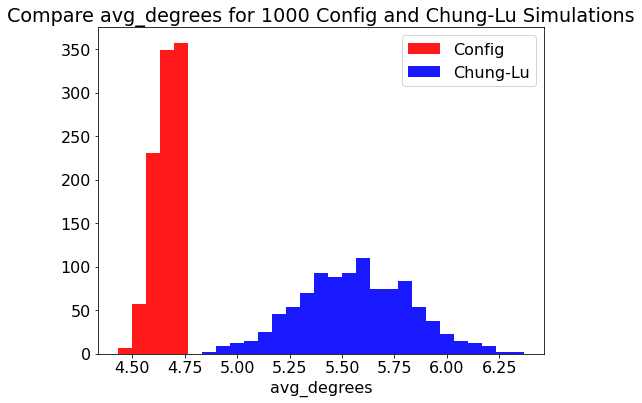

In [37]:
# compare average degrees
compare_summarries(config_df, chung_lu_df, "avg_degrees")

# (3.3) Padgett Florentine Family Analysis

In [38]:
# define string_to_array(s)
# transform string of node positions in floretine family to arrays
def string_to_array(s):
    s = ( s.lstrip("array[(") ); s = ( s.rstrip("]) ")) ; 
    s = [float(x) for x in s.split(", ")]
    return s

In [39]:
# read in florentine family dataset, basic manipulation
# read in data
flor_edges = pd.read_csv(r"florentine_edges.csv")
flor_nodes = pd.read_csv(r"florentine_nodes.csv")

# remove business relationship from data
mar_edges = []
for link in flor_edges.iloc: 
    if(link[3] != 2): mar_edges.append( [link[0],link[1]] )
# only marriage; filter out "layer" or business relationships
flor_edges = pd.DataFrame( data = mar_edges, columns = ["From", "To"])

# create "pos" dictionary for nodes to their location
node_loc = {n:string_to_array(loc) for n,loc in zip(flor_nodes[flor_nodes.columns[0]],flor_nodes[flor_nodes.columns[3]])}
# all family/node names
labeldict = {i : fam for i,fam in zip( flor_nodes[flor_nodes.columns[2]].index, flor_nodes[flor_nodes.columns[2]] )}

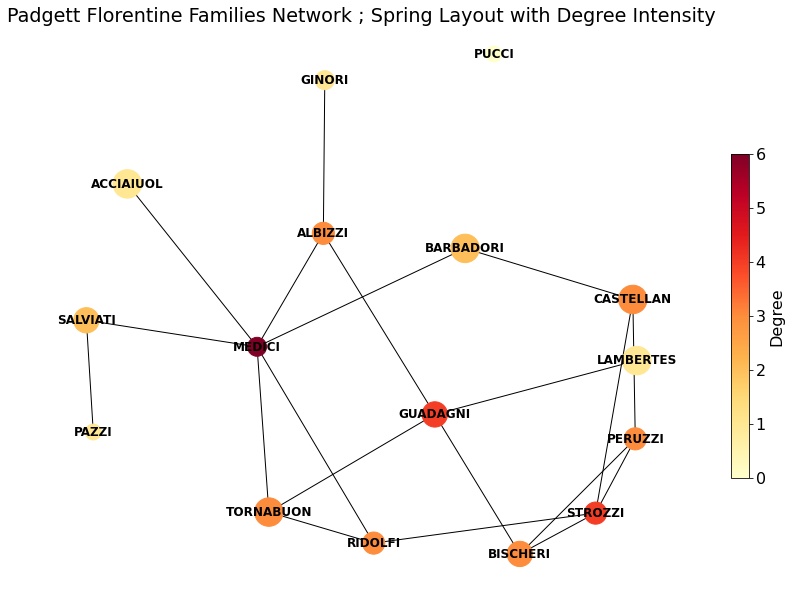

In [40]:
# draw Florentine family network
# create Graph object of Florentine Families dataset
florentine = nx.Graph()

# create edges
for link in flor_edges.iloc: florentine.add_edge( link[0], link[1] )
florentine.add_node(11)
# print node number and its respective degree
florentine_deg = [i[1] for i in florentine.degree]

# check plot of Padgett Florentine families dataset
l = nx.spring_layout
plot_network(florentine, layout = l, cmap = "YlOrRd", measure = florentine_deg, measure_label = "Degree", 
             node_labels = labeldict, positions = node_loc);
plt.title("Padgett Florentine Families Network ; Spring Layout with Degree Intensity");

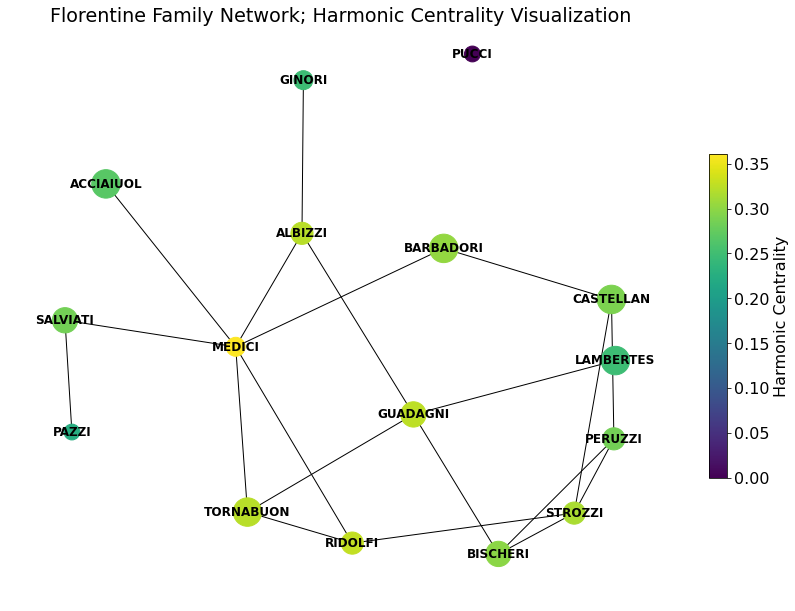

In [41]:
# (3.2) draw network based on harmonic centrality
# find harmonic centrality
hc, hc_df = harmonic_centrality(florentine)
# set nx standard
l = nx.spring_layout ; cmap = "viridis"
# draw nx graph
plot_network(florentine, layout = l, cmap = cmap, measure = hc, measure_label="Harmonic Centrality", 
             node_labels = labeldict, positions = node_loc);
plt.title("Florentine Family Network; Harmonic Centrality Visualization");

In [42]:
# compare actual harmonic centralities for nodes
# get family name from node index in given node file
fams = [flor_nodes.loc[flor_nodes.index.get_loc(i)][2] for i in hc_df["Node"]]    
# add names to dataframe with harmonic centrality; add appropriate name to appropriate node number
hc_df["Family"] = fams
hc_df["Degree"] = florentine_deg

# display values
print("\t      Table 3.1")
display(hc_df.sort_values("HC", ascending=False))

	      Table 3.1


,Node,HC,Family,Degree
8,8.0,0.361111,MEDICI,6
12,12.0,0.327778,RIDOLFI,3
6,6.0,0.324444,GUADAGNI,4
1,1.0,0.322222,ALBIZZI,3
15,15.0,0.322222,TORNABUON,3
14,14.0,0.315556,STROZZI,4
2,2.0,0.302222,BARBADORI,2
3,3.0,0.298889,BISCHERI,3
4,4.0,0.290000,CASTELLAN,3
10,10.0,0.284444,PERUZZI,3


In [43]:
# simulate 2000 networks of the family via the Config Model ; keep track of harmonic centrality for all simulations
hc_all_sims = []
# run simulations for identical degree sequences to examine differences in harmonic centrality
for sim in range(2000):
    # create a simulation of florentine data with identical degree sequence
    g_sim = config_model(florentine_deg)[1]    
    # calculate harmonic centrality for all nodes in this particular simulation
    hc_sim = harmonic_centrality( g_sim )[0]
    # append this simulation's harmonic centrality values to list
    hc_all_sims.append(hc_sim)
    
# harmonic centrality DataFrame
hc_sim_df = pd.DataFrame(data = hc_all_sims, columns = hc_df["Family"] )
simulation_summary_stats = ( np.round(hc_sim_df.describe().transpose(), 3) )

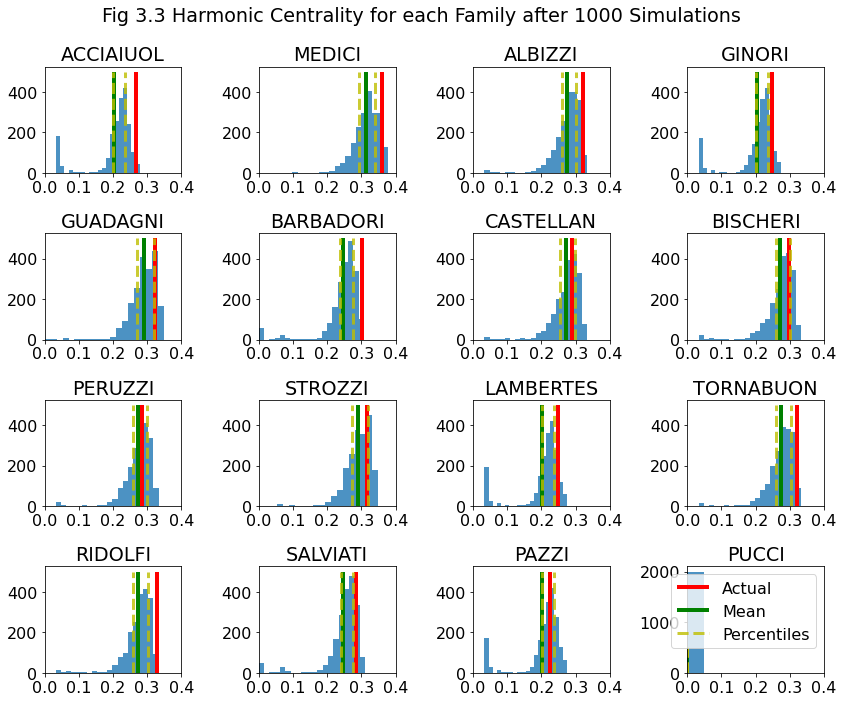

In [44]:
# Fig 3.3; simulated harmonic centrality histograms for each family 
rows = 4 ; cols = 4;  fig, axs = plt.subplots(rows,cols,figsize=(12,10));
plt.suptitle("""Fig 3.3 Harmonic Centrality for each Family after 1000 Simulations""");

# plot histograms for each family
# for each subplot axis and each family

for enum, fam in zip(enumerate(fig.axes), hc_sim_df.columns):
    # sepereate subplot number and actual axis object
    i = enum[0] ; ax = enum[1]
    # retrieve the simulated harmonic centrality values
    ax.hist( hc_sim_df[fam], bins = 20, alpha = .8 )
    
    # plot red lines for actual harmonic centrality values    
    ax.vlines(hc[i], color = "red", ymin = 0, ymax = 500, linewidth = 4)
    # plot green lines for expected harmonic centrality values    
    ax.vlines( np.mean(hc_sim_df[fam]), color = "green", ymin = 0, ymax = 500, linewidth = 4)
    # calculate and plot yellow lines for .25 and .75 percentile harmonic centrality values
    q25, q75 = ( np.quantile(hc_sim_df[fam], q =.25) , np.quantile(hc_sim_df[fam], q =.75) )
    ax.vlines(q25, color = "y", ymin = 0, ymax = 500, linewidth = 3, linestyles = "dashed", alpha = .8);
    ax.vlines(q75, color = "y", ymin = 0, ymax = 500, linewidth = 3, linestyles = "dashed", alpha = .8);
    
    # tidy up plot ; tidy x axis and create inidivudal titles
    ax.set_xlim([0, 0.4]) ; ax.set_xticks( np.linspace(0,.4,5) ) ;
    ax.set_title(str(fam)) ;

# label lines in legend
plt.legend( ["Actual","Mean","Percentiles"] )

plt.tight_layout();

# . .  .
